In [1]:
import os
import pandas as pd
os.chdir("E:\\Projects\\diffusion")
import scanpy as sc
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import warnings
from tqdm.auto import tqdm
import numpy as np
from diffusers.utils import randn_tensor
from stadiff.models import SpaUNet1DModel
from stadiff.pipeline import prepare_dataset
import torch.nn.functional as F
from diffusers import DDPMScheduler
from collections import defaultdict
from torch_geometric.loader import NeighborLoader
from stadiff import pipeline
from stadiff.analytics import mclust_R
from stadiff import utils
os.environ["R_HOME"] = r"D:\Program Files\R\R-4.0.3"
warnings.filterwarnings("ignore")
sns.set_theme("paper", style="ticks", font_scale=1.25)

In [15]:
# load RDS file
import pyreadr
result = pyreadr.read_r("E:\\Projects\\Datasets\\J20-mouse\\SpatialRNA_cropped_slideseq_j20_rep1-withoutRCTD.rds")


LibrdataError: The file contains an unrecognized object

In [2]:
adata = sc.read_h5ad("E:\\Projects\\diffusion\\dataset\\STARmap_20180505_BY3_1k.h5ad")
# normalize data
# adata = sc.read_h5ad("E:\Projects\Datasets\\19310672\\scVI_kidney_object.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label', 'region', 'Region'
    uns: 'label_colors', 'log1p'
    obsm: 'spatial'

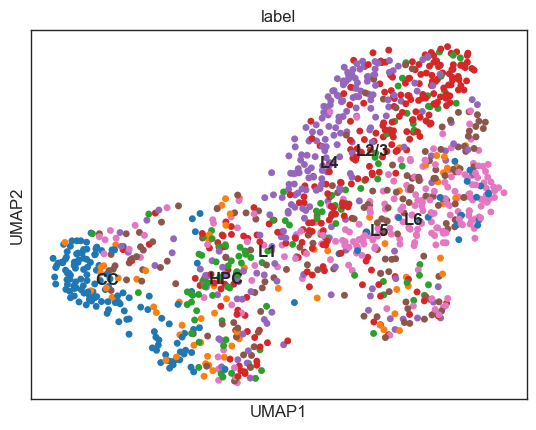

In [4]:
sc.pp.pca(adata, n_comps=30)
sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["label"], legend_loc="on data")

In [5]:
adata.obsm["spatial"].max(axis=0), adata.obsm["spatial"].min(axis=0)

(array([13803.29843707,   -37.61281062]),
 array([   56.79647508, -6435.09631914]))

## Train the autoencoder

In [6]:
from stadiff.vae import SpaAE
from stadiff.dataset import get_slice_loader
from stadiff import pipeline
model_config = {"pretrain_epochs": 500,
                "align_epochs": None,
                "diffusion_epochs": 2000,
                "gradient_clip": 5,
                "save_dir": "E:\Projects\diffusion\output\Single-MVC",
                }
save_dir = model_config["save_dir"]
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
device = torch.device("cuda:0")

In [7]:
spatial_data = adata.obsm["spatial"]
spatial_data = adata.obsm["spatial"]
new_spatial_data = utils.quantize_coordination(spatial_data, [("division", 150), ("division", 150)])
adata.obsm["spatial_new"] = new_spatial_data
adata = utils.cal_spatial_net2D(adata, rad_cutoff=2, use_obsm="spatial_new")

Quantizing spatial coordinates...
Quantize 0th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.2548813930970784, pearson correlation: 0.9999308023941088
Quantize 1th dimension of spatial coordinates to 0.006666666666666667, mean deviation: 0.25215097208251297, pearson correlation: 0.9997416628502235
------Calculating spatial graph...
------Spatial graph calculated.
The graph contains 4484 edges, 1207 cells, 3.7150 neighbors per cell on average.


In [8]:
data = pipeline.prepare_dataset(adata, use_net="Spatial_Net", use_spatial="spatial_new", device=device)

In [9]:
np.nonzero(adata.X)[0].shape / np.prod(adata.X.size)

array([0.23130107])

In [13]:
model = SpaAE(input_dim=1020,
               block_list=["AttnBlock"],
               gat_dim=[512],
               block_out_dims=[512, 32]).to(device)
train_loader = NeighborLoader(data, num_neighbors=[5, 5], batch_size=64, shuffle=True, num_workers=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
n_epochs = model_config["pretrain_epochs"]
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
loss_list = []
pbar = tqdm(range(n_epochs))
model.train()
for epoch in range(1, n_epochs + 1):
    for batch in train_loader:
        optimizer.zero_grad()
        z, out = model(batch.x, batch.edge_index)
        loss = F.mse_loss(out, batch.x)
        loss_list.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        pbar.set_description(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
        loss_list.append(loss.item())
    scheduler.step()
    pbar.update(1)
torch.save(model, os.path.join(save_dir, "pretrain_autoencoder.pth"))
# save model to disk

  0%|          | 0/500 [00:00<?, ?it/s]

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


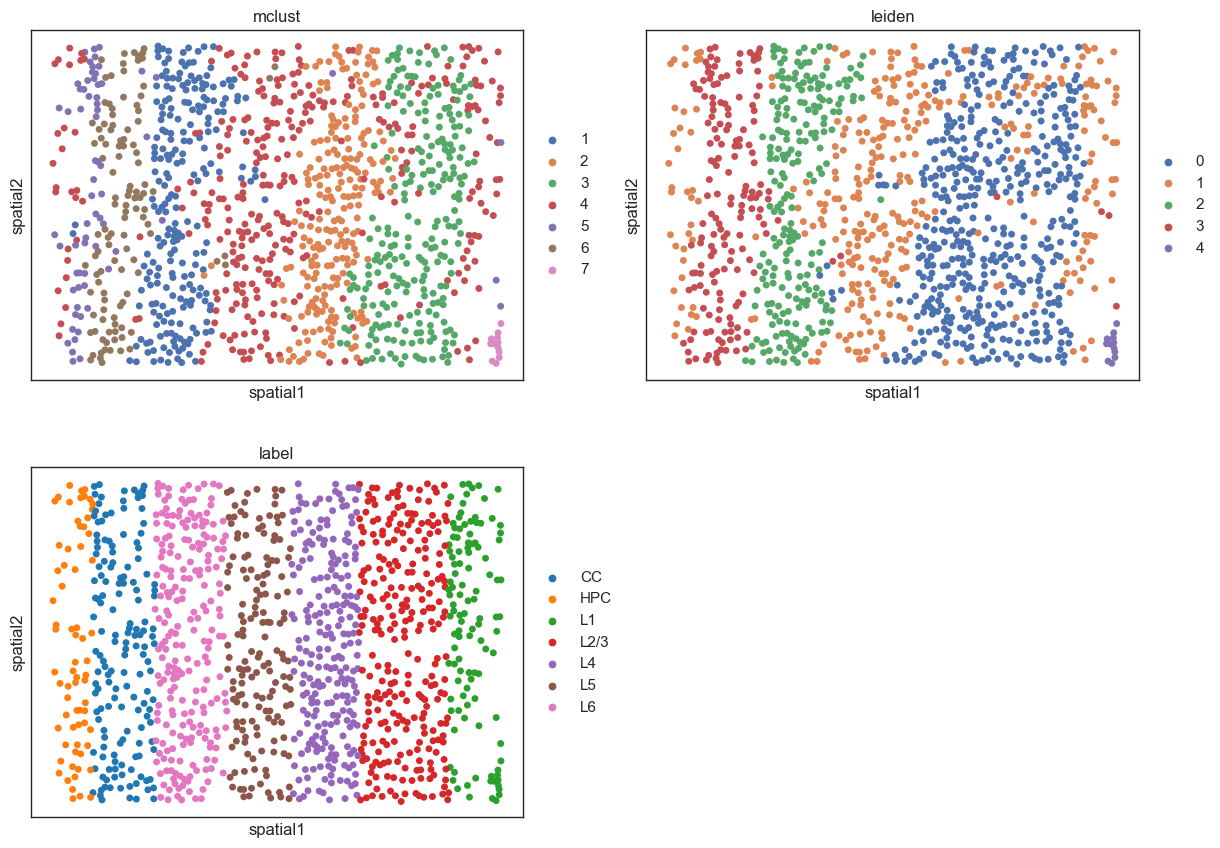

In [12]:
with torch.no_grad():
    model.eval()
    with torch.no_grad():
        z, out = model(data.x, data.edge_index)
    adata.obsm["latent"] = z.detach().cpu().numpy()
sc.pp.neighbors(adata, n_neighbors=30, use_rep="latent")
sc.tl.umap(adata, min_dist=0.5)
# perform leiden clustering
sc.tl.leiden(adata, key_added="leiden", resolution=0.35)
# perform mclust clustering
adata = mclust_R(adata, num_cluster=7, add_key="mclust", use_rep="latent")
sc.pl.embedding(adata, basis="spatial", color=["mclust", "leiden", "label"], ncols=2)

In [102]:
# import correlation
from scipy.stats import spearmanr
# compute correlation between out and x
out = out.detach().cpu().numpy()
x = data.x.detach().cpu().numpy()
# compute

In [113]:
ind = 4
spearmanr(out[:, ind], x[:, ind])

SignificanceResult(statistic=0.2153892738528369, pvalue=3.901532865174227e-14)